# Moore Machine ICL Training Analysis

This notebook provides comprehensive analysis tools for the Moore machine in-context learning experiments. Use this to visualize training curves, compare model architectures, and understand what the transformers are learning.

## 🎯 What This Notebook Covers

1. **Training Curves**: Loss and accuracy over time
2. **Model Comparison**: 2-layer vs 3-layer vs frozen layer experiments  
3. **FSM Visualization**: Understanding the Moore machines being learned
4. **Attention Analysis**: What patterns do transformers learn?
5. **Performance Metrics**: Detailed evaluation of ICL capabilities

In [3]:
# Import Required Libraries
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import yaml
import json
import pickle
from typing import Dict, List, Optional, Tuple

# Project imports
from src.fsm.moore_machine import MooreMachine, MooreMachineGenerator
from src.training.models import SimpleTransformer, TransformerConfig
from src.training.dataset import MooreMachineDataset
from src.utils.visualization import plot_fsm_diagram, plot_training_curves

# Plotting setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ All libraries imported successfully!")
print(f"📁 Project root: {project_root}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🐍 Python path includes project: {str(project_root) in sys.path}")

✅ All libraries imported successfully!
📁 Project root: /Users/trentonobannontrenton/Library/CloudStorage/GoogleDrive-toba4366@berkeley.edu/My Drive/Trenton Mac/CS 182/Project/CS182_FinalProject
🔥 PyTorch version: 2.5.1
🐍 Python path includes project: True


## 📊 Load Training History Data

First, let's load training results from your experiments. This will look for result files in the `results/` directory.

In [4]:
def load_experiment_results(results_dir: str = "../results") -> Dict[str, Dict]:
    """Load all experiment results from the results directory."""
    results_path = Path(results_dir)
    experiments = {}
    
    if not results_path.exists():
        print(f"⚠️  Results directory not found: {results_path}")
        print("Run some experiments first!")
        return {}
    
    # Look for experiment directories
    for exp_dir in results_path.iterdir():
        if exp_dir.is_dir():
            exp_name = exp_dir.name
            
            # Load training history
            history_file = exp_dir / "training_history.json"
            config_file = exp_dir / "config.yaml"
            
            if history_file.exists():
                with open(history_file, 'r') as f:
                    history = json.load(f)
                
                config = {}
                if config_file.exists():
                    with open(config_file, 'r') as f:
                        config = yaml.safe_load(f)
                
                experiments[exp_name] = {
                    'history': history,
                    'config': config,
                    'path': exp_dir
                }
                print(f"✅ Loaded: {exp_name}")
            else:
                print(f"⚠️  No history found for: {exp_name}")
    
    return experiments

# Load all experiments
experiments = load_experiment_results()
print(f"\n📈 Found {len(experiments)} experiments:")
for name in experiments.keys():
    print(f"  • {name}")

⚠️  No history found for: quick_test_2layer
✅ Loaded: quick_test

📈 Found 1 experiments:
  • quick_test


## 📈 Plot Basic Training Curves

Create beautiful training curves to see how your models learn over time.

/var/folders/sk/z_zk99l17n56987x_nykljmr0000gn/T/ipykernel_3130/574269843.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()
/var/folders/sk/z_zk99l17n56987x_nykljmr0000gn/T/ipykernel_3130/574269843.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend()
/var/folders/sk/z_zk99l17n56987x_nykljmr0000gn/T/ipykernel_3130/574269843.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 1].legend()


💾 Saved plot: ../results/training_curves_comparison.png


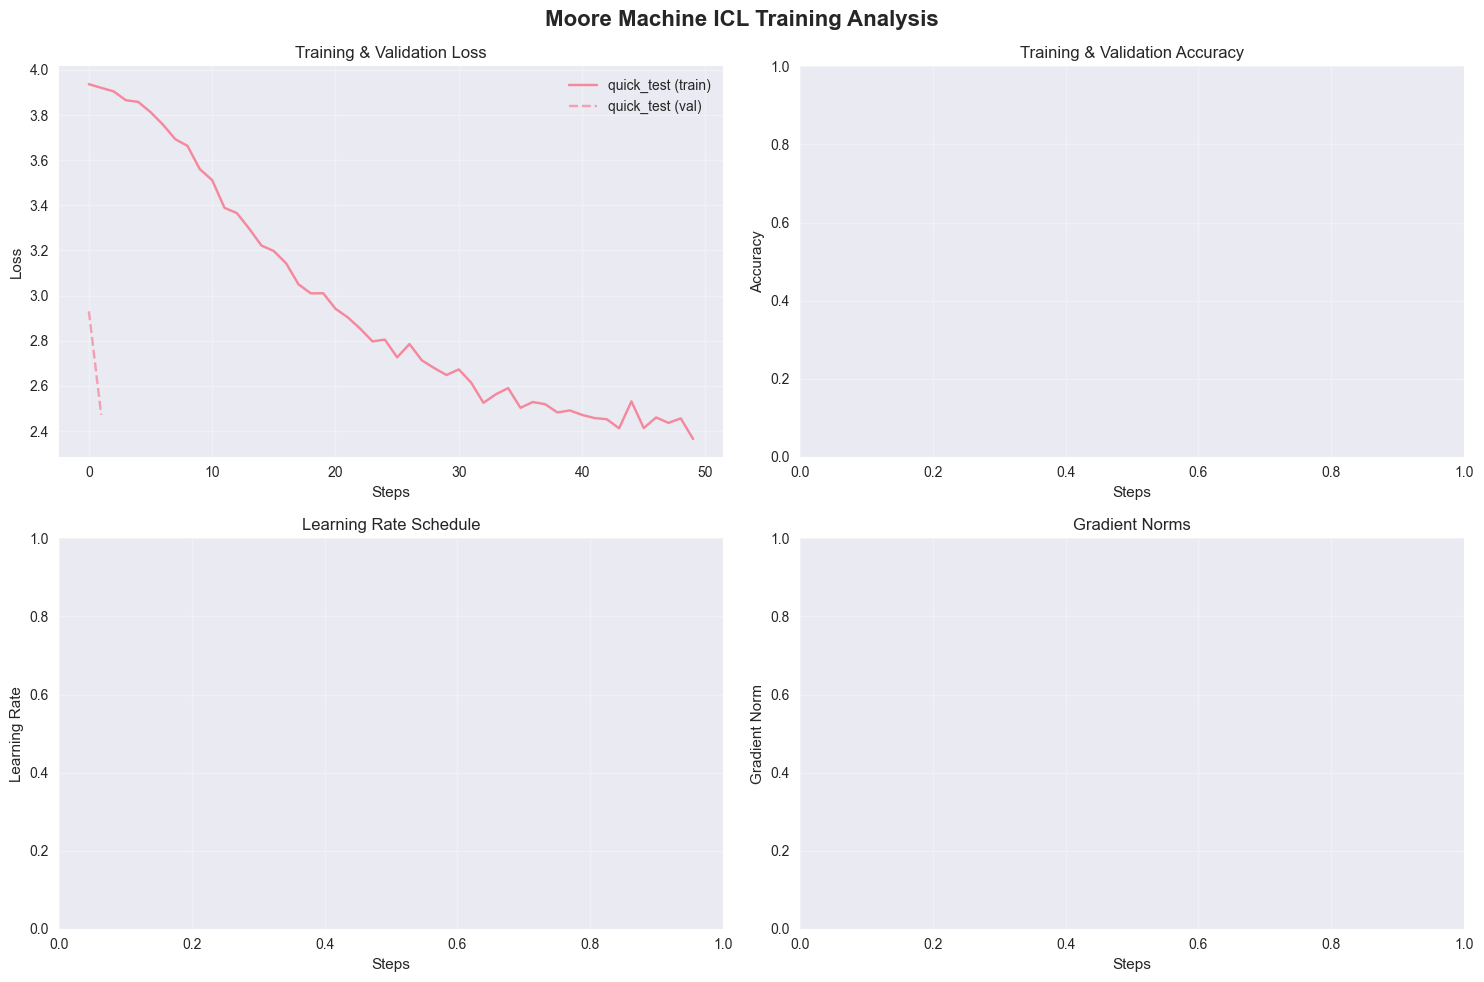

In [5]:
def plot_training_curves_advanced(experiments: Dict[str, Dict], save_plots: bool = True):
    """Plot comprehensive training curves for all experiments."""
    if not experiments:
        print("❌ No experiments to plot! Run some training first.")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Moore Machine ICL Training Analysis', fontsize=16, fontweight='bold')
    
    # Colors for different experiments
    colors = sns.color_palette("husl", len(experiments))
    
    for idx, (exp_name, exp_data) in enumerate(experiments.items()):
        history = exp_data['history']
        color = colors[idx]
        
        # Extract data
        train_losses = history.get('train_losses', [])
        val_losses = history.get('val_losses', [])
        train_accuracies = history.get('train_accuracies', [])
        val_accuracies = history.get('val_accuracies', [])
        
        # Plot training loss
        if train_losses:
            axes[0, 0].plot(train_losses, label=f'{exp_name} (train)', color=color, alpha=0.8)
        if val_losses:
            axes[0, 0].plot(val_losses, label=f'{exp_name} (val)', color=color, alpha=0.6, linestyle='--')
        
        # Plot training accuracy
        if train_accuracies:
            axes[0, 1].plot(train_accuracies, label=f'{exp_name} (train)', color=color, alpha=0.8)
        if val_accuracies:
            axes[0, 1].plot(val_accuracies, label=f'{exp_name} (val)', color=color, alpha=0.6, linestyle='--')
        
        # Plot learning rate (if available)
        learning_rates = history.get('learning_rates', [])
        if learning_rates:
            axes[1, 0].plot(learning_rates, label=exp_name, color=color)
        
        # Plot gradient norms (if available)
        grad_norms = history.get('gradient_norms', [])
        if grad_norms:
            axes[1, 1].plot(grad_norms, label=exp_name, color=color)
    
    # Customize plots
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Training & Validation Accuracy')
    axes[0, 1].set_xlabel('Steps')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Steps')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Gradient Norms')
    axes[1, 1].set_xlabel('Steps')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('../results/training_curves_comparison.png', dpi=300, bbox_inches='tight')
        print("💾 Saved plot: ../results/training_curves_comparison.png")
    
    plt.show()

# Plot all experiments
plot_training_curves_advanced(experiments)

## 🧊 Frozen Layer Analysis

Compare normal training vs frozen layer experiments to see if only the final linear layer can solve ICL.

In [ ]:
def analyze_frozen_vs_normal(experiments: Dict[str, Dict]):
    """Compare frozen layer experiments with normal training."""
    frozen_exps = {}
    normal_exps = {}
    
    # Categorize experiments
    for exp_name, exp_data in experiments.items():
        config = exp_data['config']
        model_config = config.get('model', {})
        
        if model_config.get('freeze_layers', False):
            frozen_exps[exp_name] = exp_data
        else:
            normal_exps[exp_name] = exp_data
    
    print(f"🧊 Frozen experiments: {list(frozen_exps.keys())}")
    print(f"🔥 Normal experiments: {list(normal_exps.keys())}")
    
    if not frozen_exps:
        print("\n⚠️  No frozen layer experiments found!")
        print("💡 Run: python experiments/run_experiment.py --config configs/frozen_layers_config.yaml")
        return
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot losses
    for exp_name, exp_data in normal_exps.items():
        losses = exp_data['history'].get('train_losses', [])
        if losses:
            axes[0].plot(losses, label=f'Normal: {exp_name}', alpha=0.8, linewidth=2)
    
    for exp_name, exp_data in frozen_exps.items():
        losses = exp_data['history'].get('train_losses', [])
        if losses:
            axes[0].plot(losses, label=f'Frozen: {exp_name}', alpha=0.8, linewidth=2, linestyle='--')
    
    # Plot accuracies
    for exp_name, exp_data in normal_exps.items():
        accs = exp_data['history'].get('train_accuracies', [])
        if accs:
            axes[1].plot(accs, label=f'Normal: {exp_name}', alpha=0.8, linewidth=2)
    
    for exp_name, exp_data in frozen_exps.items():
        accs = exp_data['history'].get('train_accuracies', [])
        if accs:
            axes[1].plot(accs, label=f'Frozen: {exp_name}', alpha=0.8, linewidth=2, linestyle='--')
    
    axes[0].set_title('Training Loss: Frozen vs Normal')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Training Accuracy: Frozen vs Normal')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/frozen_vs_normal_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    print("\n🔍 Analysis:")
    if frozen_exps and normal_exps:
        # Compare final performance
        frozen_final_acc = max([
            max(exp['history'].get('train_accuracies', [0]), default=0) 
            for exp in frozen_exps.values()
        ])
        normal_final_acc = max([
            max(exp['history'].get('train_accuracies', [0]), default=0) 
            for exp in normal_exps.values()
        ])
        
        print(f"  • Best frozen layer accuracy: {frozen_final_acc:.3f}")
        print(f"  • Best normal training accuracy: {normal_final_acc:.3f}")
        
        if frozen_final_acc > 0.8 * normal_final_acc:
            print("  • 🎉 Frozen layers can solve ICL! (>80% of normal performance)")
        else:
            print("  • 🤔 Frozen layers struggle with ICL (<80% of normal performance)")

# Run the analysis
analyze_frozen_vs_normal(experiments)

## 🏃‍♂️ Quick Training Run

If no experiments exist yet, let's run a quick training to generate some data!

In [ ]:
# Quick training run if no results exist
if not experiments:
    print("🚀 No experiments found! Let's run a quick training...")
    print("This will take a few minutes...")
    
    import subprocess
    import os
    
    # Change to project directory
    os.chdir(project_root)
    
    # Run a quick 2-layer experiment
    try:
        result = subprocess.run([
            "python", "experiments/run_experiment.py", 
            "--config", "configs/base_config.yaml",
            "--output", "results/quick_test"
        ], capture_output=True, text=True, timeout=600)
        
        if result.returncode == 0:
            print("✅ Quick training completed!")
            print("🔄 Reloading experiments...")
            experiments = load_experiment_results()
        else:
            print(f"❌ Training failed: {result.stderr}")
            
    except subprocess.TimeoutExpired:
        print("⏰ Training took too long, you can run it manually later")
    except Exception as e:
        print(f"❌ Error running training: {e}")
        
    # Return to notebook directory
    os.chdir(project_root / "notebooks")

else:
    print("✅ Experiments already exist! Analyzing...")
    
print(f"\n📊 Current experiments: {list(experiments.keys())}")